# Task 1. Default Delay-Match-To-Sample (DMTS):

[This notebook implements task 1 as well, also using MNIST images. However this time the

A) Encoding of tasks

b) Model architecure

are different]

A sample image is presented and then, after a time delay of arbitrary duration, a test image is presented. The
goal is to evaluate the model's ability to retain the sample image in working memory during the delay period
and compare it to the test image. To titrate difficulty, the similarity between sample and test images can be
varied, and the model's invariance to image transformations and zero-shot generalization ability will also be
evaluated.


This notebook is structured as follows : 
1. Load task 1 and visualize it
2. Train (and evaluate/validate) a new architecture


[The two key differences with previous approaches are : 

a. Every time step (every image) has an associated label

b. The model produces one output per time step (per image)

]

In [13]:
import os
import numpy as np
from array import array
import matplotlib.pyplot as plt
import importlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from tqdm.auto import tqdm
import torch.optim as optim


from sklearn.metrics import accuracy_score

# Custom functions and modules
from src.utils.process_images import *
from src.utils.metrics import *
from src.data_funs.task_loading import *
from src.data_funs.task_visualizing import *
from src.models import ConvLSTMClassifier

In [12]:
# Reload the packages
import src.utils.process_images
importlib.reload(src.utils.process_images)

import src.utils.metrics
importlib.reload(src.utils.metrics)

import src.data_funs.task_loading
importlib.reload(src.data_funs.task_loading)

import src.data_funs.task_visualizing
importlib.reload(src.data_funs.task_visualizing)

importlib.reload(src.models)

<module 'src.models' from '/Users/angelglh/Documents/github_angelglh/working_memory/src/models.py'>

In [2]:
# import os
# os.chdir('..')
os.getcwd()

'/Users/angelglh/Documents/github_angelglh/working_memory'

## 1. Load (and visualize) task 1

In [6]:
raw_MNIST = os.getcwd() + '/data/MNIST/raw'
delay_images = 3

# Training data
training_MNIST = task1_Dataset_MNIST(is_train_data = True, 
                                     delay_length=delay_images,
                                     data_processing_fun=load_mnist, 
                                     data_args= (raw_MNIST + '/train-images-idx3-ubyte', raw_MNIST + '/train-labels-idx1-ubyte')
                    )

training_loader_MNIST = DataLoader(training_MNIST, batch_size=64, shuffle=True)


# Training and validation data

testing_all_MNIST = task1_Dataset_MNIST(is_train_data = False, 
                                     delay_length=delay_images,
                                     data_processing_fun=load_mnist, 
                                     data_args= (raw_MNIST + '/t10k-images-idx3-ubyte', raw_MNIST + '/t10k-labels-idx1-ubyte')
                    )

test_size = len(testing_all_MNIST) //2
testing_MNIST, valid_MNIST = random_split(testing_all_MNIST, [test_size, len(testing_all_MNIST) - test_size])

testing_loader_MNIST = DataLoader(testing_MNIST, batch_size=64, shuffle=True)
valid_loader_MNIST = DataLoader(valid_MNIST, batch_size=64, shuffle=True)


Training data ...


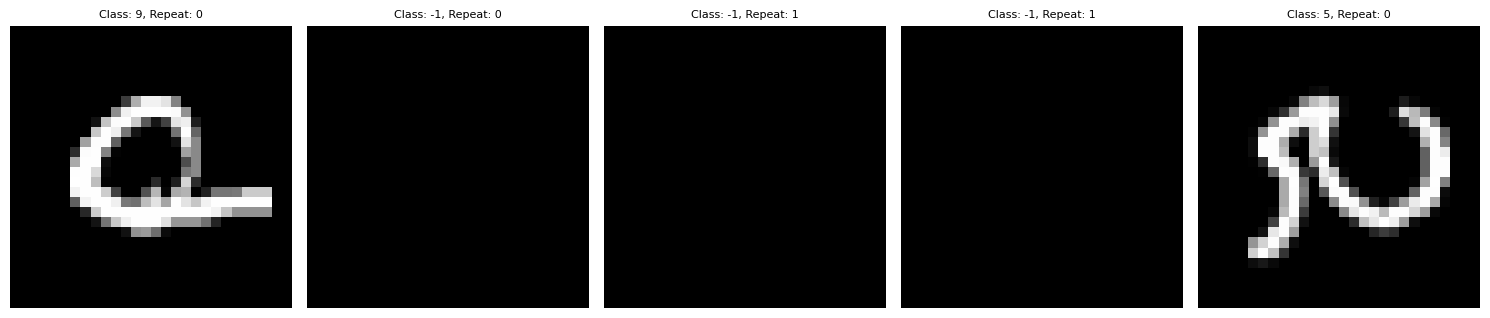

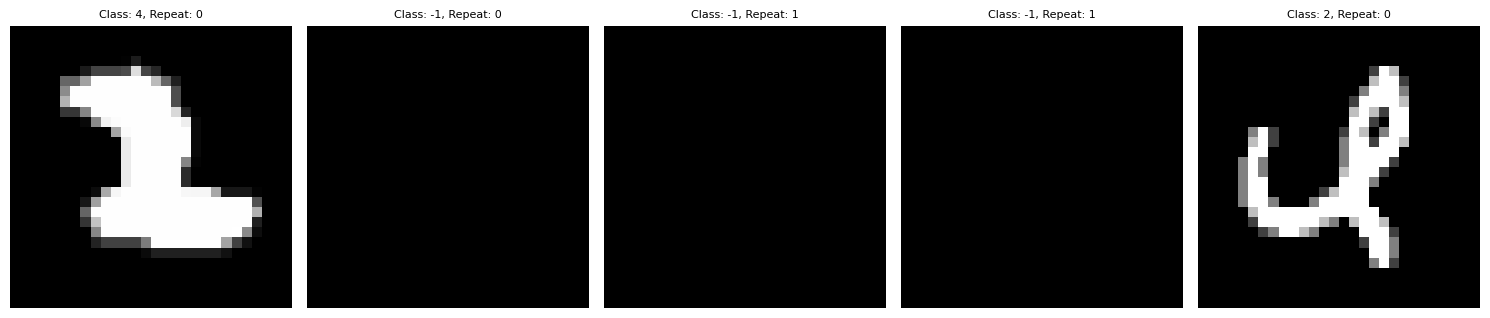


Testing data ...


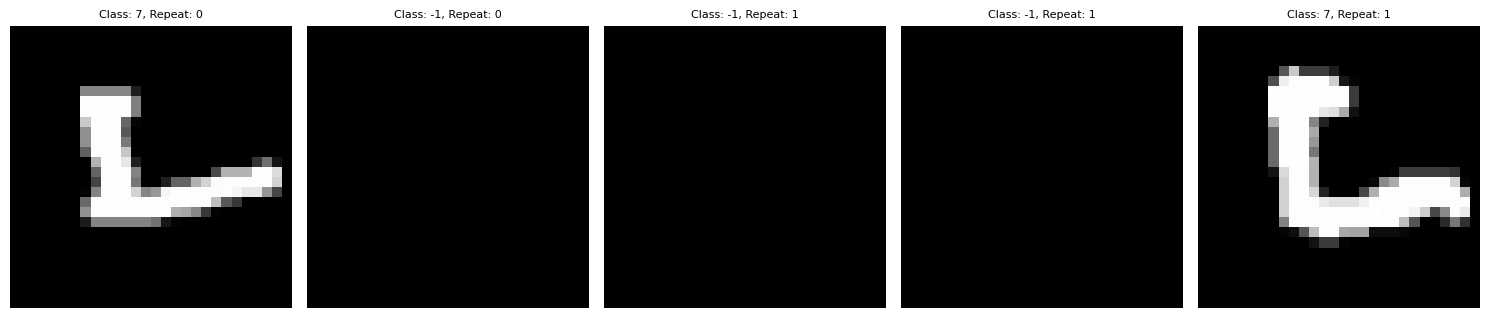

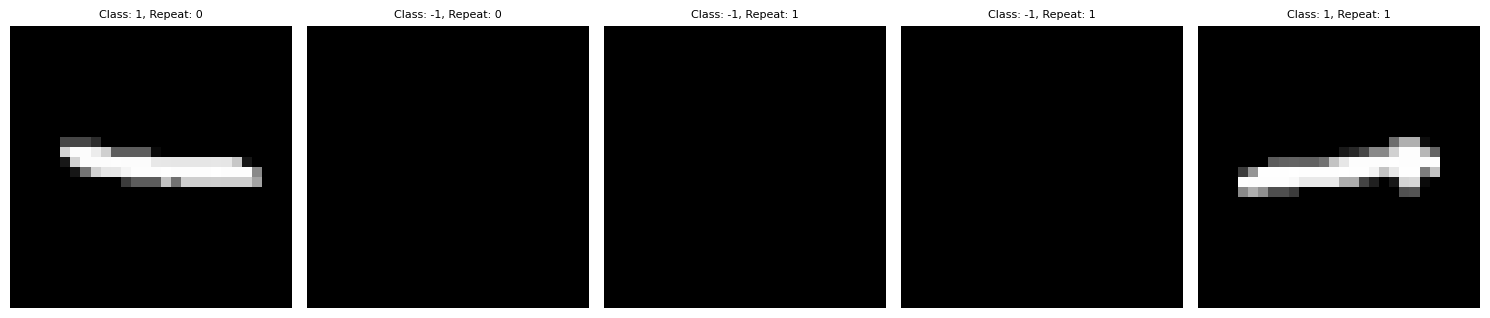


Validation data ...


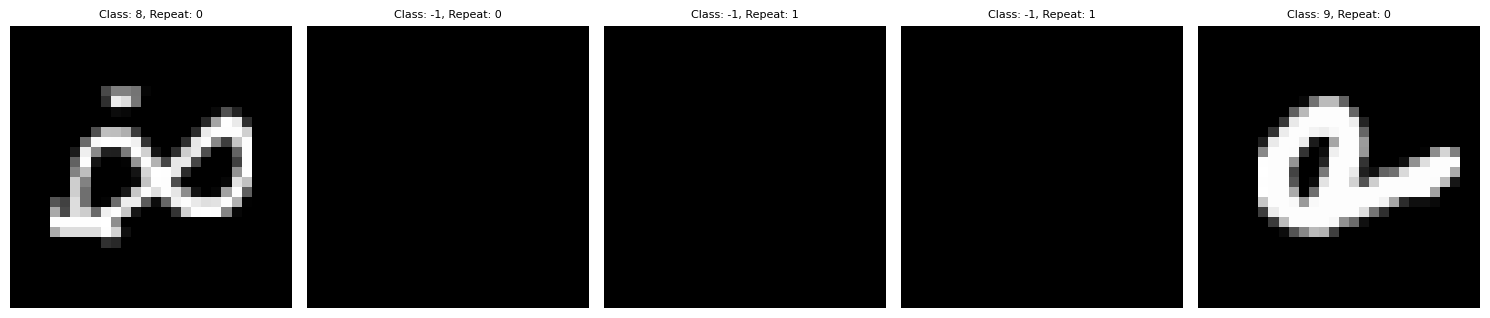

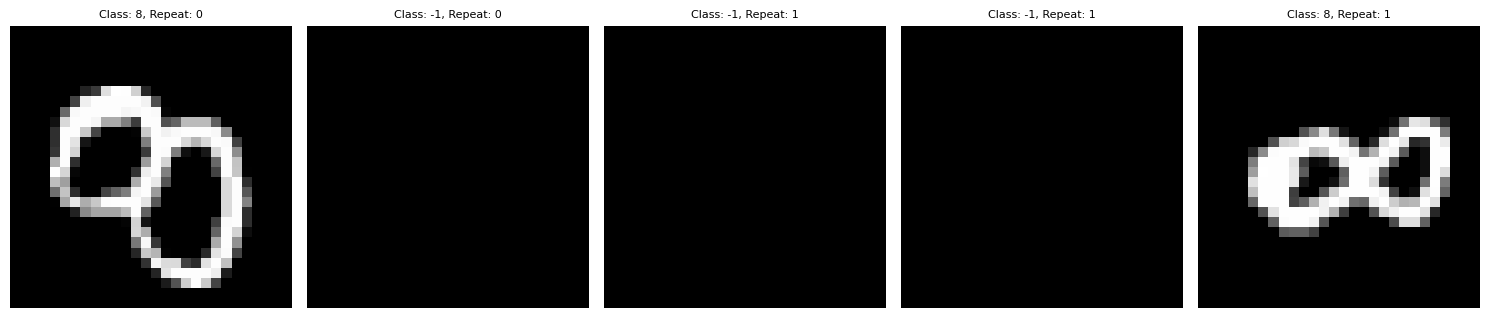

In [7]:
n_images_to_show = 2

# Visualize training, test and validation data
print("\nTraining data ...")
for sequences, class_labels, repeat_labels, match_labels in training_loader_MNIST:
    for i in range(n_images_to_show):
        show_image_sequence(sequences[i], class_labels[i], repeat_labels[i])
    break  

print("\nTesting data ...")
for sequences, class_labels, repeat_labels, match_labels in testing_loader_MNIST:
    for i in range(n_images_to_show):
        show_image_sequence(sequences[i], class_labels[i], repeat_labels[i])
    break  

print("\nValidation data ...")
for sequences, class_labels, repeat_labels, match_labels in  valid_loader_MNIST:
    for i in range(n_images_to_show):
        show_image_sequence(sequences[i], class_labels[i], repeat_labels[i])
    break  

## 2. Train the newly created architecture (ConvNet embedder > Working Memory model > Linear classifier per time step)

In [14]:
# Initialize the ConvLSTMClassifier 

input_dim = 1  # Grey images present only 1 channel
hidden_dim = 128  # LSTM hidden units
num_layers = 2  # Number of LSTM layers
num_classes = 10 # Number of classes 

model = ConvLSTMClassifier(input_dim, hidden_dim, num_layers, num_classes)
print(model)

ConvLSTMClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(3136, 128, num_layers=2, batch_first=True)
  (classifier): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 5
early_stopping_patience = 3

# Initialize the model
ignore_class = -1

input_dim = 1  # Grey images present only 1 channel
hidden_dim = 128  # LSTM hidden units
num_layers = 2  # Number of LSTM layers
num_classes = 10 # Number of classes 

model = ConvLSTMClassifier(input_dim, hidden_dim, num_layers, num_classes)
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=ignore_class) # ignore the black noise class to avoid biasing the model to the noise images
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Training loop
for epoch in range(num_epochs):
    train_loader_with_progress = tqdm(training_loader_MNIST, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)
    
    for i, (sequence, model_classes, repeats, match_tensor) in enumerate(train_loader_with_progress):
        # Move tensors to the configured device
        images = sequence.to(device)
        labels = model_classes.to(device)
        
        # Forward pass
        outputs = model(images)
        
        loss = average_loss_multiclass(outputs=outputs, labels=labels, criterion=criterion)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update the progress bar with the loss information
        train_loader_with_progress.set_postfix(loss=loss.item())


    # Testing phase
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for sequence, model_classes, repeats, match_tensor in testing_loader_MNIST:
            images = sequence.to(device)
            labels = model_classes.to(device)

            outputs = model(images)
            loss = average_loss_multiclass(outputs=outputs, labels=labels, criterion=criterion)
            test_loss += loss.item()

    test_loss /= len(testing_loader_MNIST)
    print(f'Validation Loss: {test_loss:.4f}')
    
    # Check if validation loss improved
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # Early stopping check
    if epochs_no_improve == early_stopping_patience:
        print('Early stopping triggered. Training stopped.')
        break

In [42]:
# Save the model (if needed)
models_directory = os.getcwd() + "/models"
torch.save(model.state_dict(), models_directory + "/model_task1_MNIST_classes.pt")

## 3. Model performance evaluation

In [41]:
individual_accuracy, sequence_accuracy = accuracy_of_class_labels(model, valid_loader_MNIST, device, noise_image_class = -1)

print(f'Individual Image Accuracy: {individual_accuracy * 100:.2f}%')
print(f'Whole Sequence Accuracy: {sequence_accuracy * 100:.2f}%')

Individual Image Accuracy: 98.03%
Whole Sequence Accuracy: 96.08%
